## Классификация заголовоков новостей на фейковые и настоящие 

# 0. Установка и подгрузука библиотек
Установка библиотек, под которым запускается данный бейзлайн.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 100)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix
from random import sample
import random

import tqdm
from copy import deepcopy
import re

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logger = logging.getLogger()
logging.disable(logging.ERROR)

from simple_elmo import ElmoModel

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
def seed_everything(seed = 1234):
     random.seed(seed)
     os.environ['PYTHONHASHSEED'] = str(seed)
     np.random.seed(seed)     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.backends.cudnn.deterministic = True

seed_everything()

# 1. Загрузим датасет

In [2]:
data = pd.read_csv("dataset/train.tsv", sep="\t")
data.head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
1,Агент Кокорина назвал езду по встречке житейской историей,0
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
4,Против Навального завели дело о недоносительстве на Волкова,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем состоянии,0
9,Microsoft объявила дату выхода очков дополненной реальности Hololens,0


* Датасет загружен, проанализируем его содержимое

# 2. Препроцессинг заголовков новостей
1. Токенизация — разобьём каждый заголовок статьи на слова.
2. Нормализация — приведём слова к «рафинированному» виду (единый регистр слов, отсутствие знаков пунктуации, расшифрованные сокращения, словесное написание чисел и т.д.).
3. Стеммизация — приведём слова к его корню путем устранения придатков (суффикса, приставки, окончания).
4. Лемматизация — приведём слова к начальной форме.
5. Чистка — удаленим стоп-слова, которые не несут смысловой нагрузки (артикли, междометья).

* Для этого будем использовать библиотеку pymorphy2

In [3]:
import pymorphy2
count = 0
all_words = []
all_pre_words = []


def sentence_editor(title):
    global count
    txt = re.sub(pattern, "", title)
    txt = txt.strip(" ").lower()
    txt = txt.split() # Tokenizing
    all_pre_words.extend(txt)
    new_txt = []
    for word in txt:
        word = morph.parse(word)[0]
        if word.tag.POS not in ["PRCL", "INTJ", "PREP", "CONJ"]:
            new_txt.append(word.normal_form) # Lemmatizing
        else:
            count += 1
    all_words.extend(new_txt)
    txt = " ".join(new_txt)
    return txt


morph = pymorphy2.MorphAnalyzer()
new_title = []
pattern = "[^а-яА-Яa-zA-Z ё]"

for txt in tqdm.notebook.tqdm(data.title):
    new_title.append(sentence_editor(txt))

start = random.randint(0, len(new_title))
print(*new_title[start:start + 10], sep="\n")
print("DELETED", count, "words")

  0%|          | 0/5758 [00:00<?, ?it/s]

sony создать новый контроллер playstation
король бургер обогнать gears of war
гогольцентр отменить спектакль изз антивоенный бойкот актриса
лужники спартак выиграть португальский спортинг
цска упустить победа фенербахча
кризис оставить работа четверть население греция
российский радиостанция оштрафовать отсутствие титр латышский язык
подарить алексей навальный валентинка наслать след новичок
российский прокат выходить затоiчить такести китано
фас запретить авиакомпания продавать невозвратный билет
DELETED 8337 words


# 3. Визуализация данных


### Есть ли дисбаланс классов?

<AxesSubplot:xlabel='is_fake', ylabel='count'>

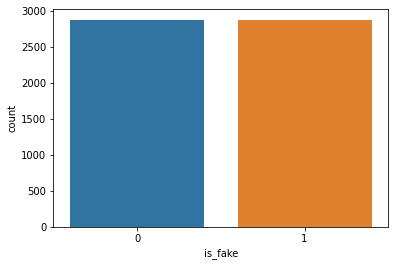

In [4]:
sns.countplot(x=data["is_fake"])

* Колличество фейковых и реальных новостей полностью совпадает, что не может не радовать

### Топ самых частых слов до удаления стоп-слов

In [5]:
NUMBER = 30
count_words = {}
for word in all_pre_words:
    if word in count_words:
        count_words[word] += 1
    else:
        count_words[word] = 1

most_frequency_words = {"word": sorted(count_words, key=lambda x: -count_words[x])[:NUMBER], 
                        "number": []}
for word in most_frequency_words["word"]:
    most_frequency_words["number"].append(count_words[word])


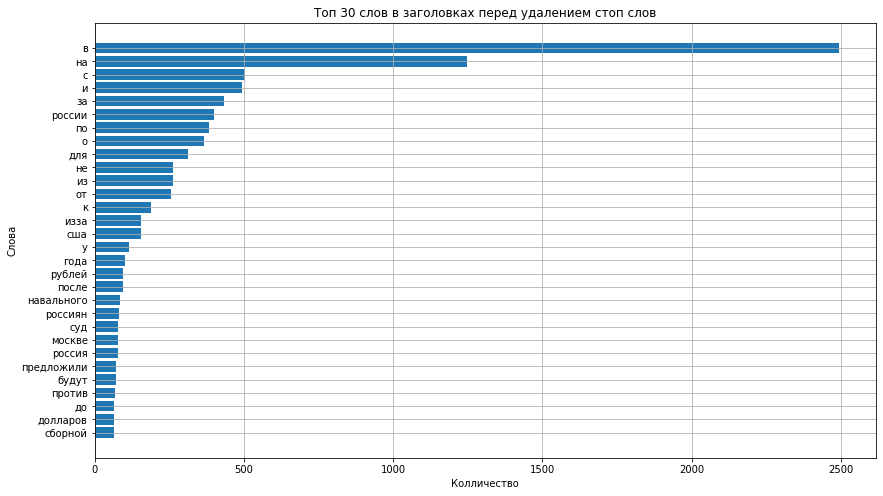

In [6]:
plt.figure(figsize=(14,8))
plt.barh(most_frequency_words["word"][::-1], most_frequency_words["number"][::-1])
plt.ylabel("Слова")
plt.xlabel("Колличество")
plt.title("Топ %d слов в заголовках перед удалением стоп слов" % (NUMBER))
plt.grid(True)

In [7]:
NUMBER = 30
count_words = {}
for word in all_words:
    if word in count_words:
        count_words[word] += 1
    else:
        count_words[word] = 1

most_frequency_words = {"word": sorted(count_words, key=lambda x: -count_words[x])[:NUMBER], 
                        "number": []}
for word in most_frequency_words["word"]:
    most_frequency_words["number"].append(count_words[word])


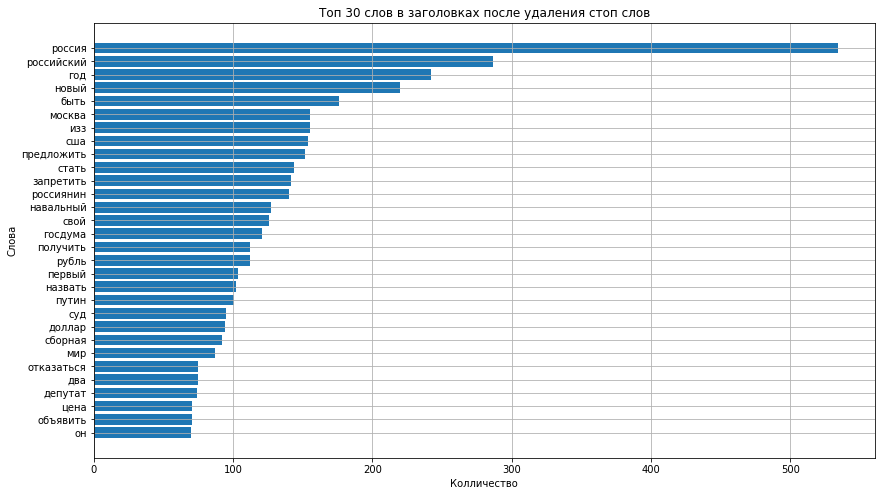

In [8]:
plt.figure(figsize=(14,8))
plt.barh(most_frequency_words["word"][::-1], most_frequency_words["number"][::-1])
plt.ylabel("Слова")
plt.xlabel("Колличество")
plt.title("Топ %d слов в заголовках после удаления стоп слов" % (NUMBER))
plt.grid(True)

# 4. Переведём каждый обработанный заголовок в векторное представление
* с помощью контекстуализированной модели от RusVectōrēs натренерованной на около 10 миллиардов слов
* будем создавать вектор для каждого слова, а в качестве вектора предложения будем брать среднее значение между всеми словами в нём

In [9]:
elmo_model = ElmoModel()
elmo_model.load("sentence_embender")

c:\users\vush6\pycharmprojects\fake or real title of news\venv\lib\site-packages\simple_elmo\model.py:529: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
c:\users\vush6\pycharmprojects\fake or real title of news\venv\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
c:\users\vush6\pycharmprojects\fake or real title of news\venv\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
c:\users\vush6\pycharmprojects\fake or real title of

'The model is now loaded.'

In [10]:
new_title[0]

'москвич владимир клутина прийти счёт вмешательство американский выборы'

In [11]:
title_matrix = np.array([[0] * 1024], dtype=float)
batch_size = 32
for i in tqdm.notebook.tqdm(range(0, len(new_title), batch_size)):
    title_matrix = np.append(title_matrix, 
                             elmo_model.get_elmo_vector_average([x.split() for x in new_title[i:i + batch_size]]),
                             axis=0)

title_matrix = np.delete(title_matrix, 0, axis=0)
title_matrix.shape

  0%|          | 0/180 [00:00<?, ?it/s]

(5758, 1024)

In [12]:
print(data.shape)
print(title_matrix.shape)

(5758, 2)
(5758, 1024)


# 5. Разделим датасет на обучающую, валидационную и тестовую подвыборки

In [25]:
import pickle

with open('files/title_emb_X.pickle', 'wb') as f:
    pickle.dump(X, f)
with open('files/title_emb_Y.pickle', 'wb') as f:
    pickle.dump(Y, f)

In [13]:
x = np.concatenate((np.array(data.drop("is_fake", axis=1)), title_matrix), axis=1)
y = np.array([np.array(data[data.title == title[0]].is_fake)[0] for title in x])

In [17]:
X = title_matrix
Y = y

In [18]:
x

array([['Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
        -0.026137593794597208, -0.03709144557447718, ...,
        0.019916739216694315, -0.007809336559148129,
        -0.07590965777116687],
       ['Агент Кокорина назвал езду по встречке житейской историей',
        0.0045856463767328754, 0.012149634418496334, ...,
        0.04233165955172, 0.1038698998738525, -0.059589282419974195],
       ['Госдума рассмотрит возможность введения секретных статей Уголовного кодекса',
        0.016818846771092983, -0.08118769593812755, ...,
        -0.0031721681378487033, 0.000560379545336687,
        -0.018380930701067475],
       ...,
       ['«Мне стыдно перед дедом»: новый канцлер ФРГ обратился с первой речью к Бундестагу',
        -0.029480071644749972, -0.04626696189487515, ...,
        0.008875949963536522, 0.015297313644998036,
        -0.026672368018459965],
       ['Туркмения в декабре начнет поставки газа в Китай',
        -0.020441723371993712, -0.0

In [19]:
print(x.shape)
print(y.shape)

(5758, 1025)
(5758,)


In [20]:
from sklearn.model_selection import train_test_split

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x, np.array(y), test_size=0.15, random_state=1, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=1, shuffle=True)

In [21]:
train_title = [x[0] for x in X_train]
test_title = [x[0] for x in X_test]
val_title = [x[0] for x in X_val]

X_train = np.array([x[1:] for x in X_train], dtype=np.float64)
X_test = np.array([x[1:] for x in X_test], dtype=np.float64)
X_val = np.array([x[1:] for x in X_val], dtype=np.float64)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(4159, 1024)
(864, 1024)
(735, 1024)
(4159,)
(864,)
(735,)


# 6. Здесь определяем саму линейную модель

In [28]:
from catboost import CatBoostRegressor, Pool

eval_dataset = Pool(X_val, Y_val)

model = CatBoostRegressor(learning_rate=0.03)
# Fit model
model.fit(X_train, Y_train, eval_set=eval_dataset,
          verbose=True, plot=True, use_best_model=True)
print(model.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4956204	test: 0.4960933	best: 0.4960933 (0)	total: 118ms	remaining: 1m 58s
1:	learn: 0.4909911	test: 0.4919873	best: 0.4919873 (1)	total: 230ms	remaining: 1m 54s
2:	learn: 0.4867151	test: 0.4880209	best: 0.4880209 (2)	total: 341ms	remaining: 1m 53s
3:	learn: 0.4829747	test: 0.4846556	best: 0.4846556 (3)	total: 452ms	remaining: 1m 52s
4:	learn: 0.4786977	test: 0.4809486	best: 0.4809486 (4)	total: 562ms	remaining: 1m 51s
5:	learn: 0.4746948	test: 0.4774161	best: 0.4774161 (5)	total: 681ms	remaining: 1m 52s
6:	learn: 0.4709151	test: 0.4740623	best: 0.4740623 (6)	total: 819ms	remaining: 1m 56s
7:	learn: 0.4673181	test: 0.4707731	best: 0.4707731 (7)	total: 962ms	remaining: 1m 59s
8:	learn: 0.4636057	test: 0.4676122	best: 0.4676122 (8)	total: 1.11s	remaining: 2m 2s
9:	learn: 0.4605092	test: 0.4647511	best: 0.4647511 (9)	total: 1.24s	remaining: 2m 2s
10:	learn: 0.4575352	test: 0.4620241	best: 0.4620241 (10)	total: 1.38s	remaining: 2m 3s
11:	learn: 0.4544827	test: 0.4593674	best: 0

94:	learn: 0.3369550	test: 0.3700630	best: 0.3700630 (94)	total: 11.4s	remaining: 1m 48s
95:	learn: 0.3363232	test: 0.3697584	best: 0.3697584 (95)	total: 11.5s	remaining: 1m 48s
96:	learn: 0.3356870	test: 0.3692737	best: 0.3692737 (96)	total: 11.6s	remaining: 1m 48s
97:	learn: 0.3351737	test: 0.3689848	best: 0.3689848 (97)	total: 11.8s	remaining: 1m 48s
98:	learn: 0.3347025	test: 0.3687066	best: 0.3687066 (98)	total: 11.9s	remaining: 1m 48s
99:	learn: 0.3340385	test: 0.3682048	best: 0.3682048 (99)	total: 12s	remaining: 1m 47s
100:	learn: 0.3333343	test: 0.3679763	best: 0.3679763 (100)	total: 12.1s	remaining: 1m 47s
101:	learn: 0.3327565	test: 0.3676715	best: 0.3676715 (101)	total: 12.2s	remaining: 1m 47s
102:	learn: 0.3321357	test: 0.3673173	best: 0.3673173 (102)	total: 12.3s	remaining: 1m 47s
103:	learn: 0.3314441	test: 0.3669423	best: 0.3669423 (103)	total: 12.4s	remaining: 1m 47s
104:	learn: 0.3309508	test: 0.3666478	best: 0.3666478 (104)	total: 12.5s	remaining: 1m 46s
105:	learn: 0

186:	learn: 0.2973859	test: 0.3506700	best: 0.3506700 (186)	total: 22.4s	remaining: 1m 37s
187:	learn: 0.2969629	test: 0.3505602	best: 0.3505602 (187)	total: 22.5s	remaining: 1m 37s
188:	learn: 0.2966431	test: 0.3504736	best: 0.3504736 (188)	total: 22.6s	remaining: 1m 37s
189:	learn: 0.2963243	test: 0.3503079	best: 0.3503079 (189)	total: 22.7s	remaining: 1m 36s
190:	learn: 0.2960880	test: 0.3502125	best: 0.3502125 (190)	total: 22.8s	remaining: 1m 36s
191:	learn: 0.2957301	test: 0.3501384	best: 0.3501384 (191)	total: 23s	remaining: 1m 36s
192:	learn: 0.2953726	test: 0.3500536	best: 0.3500536 (192)	total: 23.1s	remaining: 1m 36s
193:	learn: 0.2950026	test: 0.3499732	best: 0.3499732 (193)	total: 23.2s	remaining: 1m 36s
194:	learn: 0.2946998	test: 0.3498428	best: 0.3498428 (194)	total: 23.3s	remaining: 1m 36s
195:	learn: 0.2944208	test: 0.3496559	best: 0.3496559 (195)	total: 23.4s	remaining: 1m 36s
196:	learn: 0.2942522	test: 0.3496012	best: 0.3496012 (196)	total: 23.5s	remaining: 1m 35s
1

278:	learn: 0.2717127	test: 0.3433487	best: 0.3433487 (278)	total: 33.7s	remaining: 1m 26s
279:	learn: 0.2715311	test: 0.3432985	best: 0.3432985 (279)	total: 33.8s	remaining: 1m 26s
280:	learn: 0.2711796	test: 0.3432260	best: 0.3432260 (280)	total: 33.9s	remaining: 1m 26s
281:	learn: 0.2709345	test: 0.3431334	best: 0.3431334 (281)	total: 34s	remaining: 1m 26s
282:	learn: 0.2706693	test: 0.3429250	best: 0.3429250 (282)	total: 34.2s	remaining: 1m 26s
283:	learn: 0.2704198	test: 0.3428575	best: 0.3428575 (283)	total: 34.3s	remaining: 1m 26s
284:	learn: 0.2701742	test: 0.3428421	best: 0.3428421 (284)	total: 34.4s	remaining: 1m 26s
285:	learn: 0.2698178	test: 0.3427422	best: 0.3427422 (285)	total: 34.6s	remaining: 1m 26s
286:	learn: 0.2695441	test: 0.3426382	best: 0.3426382 (286)	total: 34.8s	remaining: 1m 26s
287:	learn: 0.2693417	test: 0.3426976	best: 0.3426382 (286)	total: 35s	remaining: 1m 26s
288:	learn: 0.2691198	test: 0.3425828	best: 0.3425828 (288)	total: 35.2s	remaining: 1m 26s
289

369:	learn: 0.2465784	test: 0.3374425	best: 0.3374425 (369)	total: 46.1s	remaining: 1m 18s
370:	learn: 0.2463244	test: 0.3374515	best: 0.3374425 (369)	total: 46.2s	remaining: 1m 18s
371:	learn: 0.2460243	test: 0.3373495	best: 0.3373495 (371)	total: 46.3s	remaining: 1m 18s
372:	learn: 0.2457924	test: 0.3373183	best: 0.3373183 (372)	total: 46.4s	remaining: 1m 18s
373:	learn: 0.2456220	test: 0.3373485	best: 0.3373183 (372)	total: 46.5s	remaining: 1m 17s
374:	learn: 0.2452924	test: 0.3371722	best: 0.3371722 (374)	total: 46.7s	remaining: 1m 17s
375:	learn: 0.2449710	test: 0.3370975	best: 0.3370975 (375)	total: 46.8s	remaining: 1m 17s
376:	learn: 0.2446280	test: 0.3371493	best: 0.3370975 (375)	total: 46.9s	remaining: 1m 17s
377:	learn: 0.2443640	test: 0.3371586	best: 0.3370975 (375)	total: 47s	remaining: 1m 17s
378:	learn: 0.2441057	test: 0.3371375	best: 0.3370975 (375)	total: 47.1s	remaining: 1m 17s
379:	learn: 0.2438355	test: 0.3370087	best: 0.3370087 (379)	total: 47.2s	remaining: 1m 17s
3

461:	learn: 0.2234276	test: 0.3344027	best: 0.3343407 (457)	total: 57.1s	remaining: 1m 6s
462:	learn: 0.2231767	test: 0.3343857	best: 0.3343407 (457)	total: 57.2s	remaining: 1m 6s
463:	learn: 0.2229113	test: 0.3343374	best: 0.3343374 (463)	total: 57.3s	remaining: 1m 6s
464:	learn: 0.2226139	test: 0.3341619	best: 0.3341619 (464)	total: 57.4s	remaining: 1m 6s
465:	learn: 0.2223916	test: 0.3342116	best: 0.3341619 (464)	total: 57.5s	remaining: 1m 5s
466:	learn: 0.2221714	test: 0.3341839	best: 0.3341619 (464)	total: 57.6s	remaining: 1m 5s
467:	learn: 0.2219614	test: 0.3341611	best: 0.3341611 (467)	total: 57.7s	remaining: 1m 5s
468:	learn: 0.2217760	test: 0.3340844	best: 0.3340844 (468)	total: 57.8s	remaining: 1m 5s
469:	learn: 0.2215071	test: 0.3340804	best: 0.3340804 (469)	total: 57.9s	remaining: 1m 5s
470:	learn: 0.2212691	test: 0.3340073	best: 0.3340073 (470)	total: 58s	remaining: 1m 5s
471:	learn: 0.2210209	test: 0.3339388	best: 0.3339388 (471)	total: 58.2s	remaining: 1m 5s
472:	learn: 

553:	learn: 0.2038099	test: 0.3324223	best: 0.3324025 (551)	total: 1m 8s	remaining: 55.3s
554:	learn: 0.2036233	test: 0.3323333	best: 0.3323333 (554)	total: 1m 8s	remaining: 55.1s
555:	learn: 0.2033473	test: 0.3323465	best: 0.3323333 (554)	total: 1m 8s	remaining: 55s
556:	learn: 0.2031271	test: 0.3323269	best: 0.3323269 (556)	total: 1m 8s	remaining: 54.9s
557:	learn: 0.2029155	test: 0.3322267	best: 0.3322267 (557)	total: 1m 9s	remaining: 54.8s
558:	learn: 0.2026798	test: 0.3322192	best: 0.3322192 (558)	total: 1m 9s	remaining: 54.6s
559:	learn: 0.2024458	test: 0.3321859	best: 0.3321859 (559)	total: 1m 9s	remaining: 54.5s
560:	learn: 0.2022686	test: 0.3322307	best: 0.3321859 (559)	total: 1m 9s	remaining: 54.5s
561:	learn: 0.2020642	test: 0.3321690	best: 0.3321690 (561)	total: 1m 9s	remaining: 54.4s
562:	learn: 0.2018565	test: 0.3321632	best: 0.3321632 (562)	total: 1m 9s	remaining: 54.3s
563:	learn: 0.2016407	test: 0.3321446	best: 0.3321446 (563)	total: 1m 10s	remaining: 54.2s
564:	learn:

645:	learn: 0.1856542	test: 0.3302048	best: 0.3301908 (644)	total: 1m 21s	remaining: 44.5s
646:	learn: 0.1855237	test: 0.3301594	best: 0.3301594 (646)	total: 1m 21s	remaining: 44.4s
647:	learn: 0.1854014	test: 0.3301295	best: 0.3301295 (647)	total: 1m 21s	remaining: 44.2s
648:	learn: 0.1852465	test: 0.3301345	best: 0.3301295 (647)	total: 1m 21s	remaining: 44.1s
649:	learn: 0.1850833	test: 0.3301039	best: 0.3301039 (649)	total: 1m 21s	remaining: 44s
650:	learn: 0.1849076	test: 0.3301255	best: 0.3301039 (649)	total: 1m 21s	remaining: 43.8s
651:	learn: 0.1847807	test: 0.3301569	best: 0.3301039 (649)	total: 1m 21s	remaining: 43.7s
652:	learn: 0.1845868	test: 0.3302056	best: 0.3301039 (649)	total: 1m 22s	remaining: 43.6s
653:	learn: 0.1844074	test: 0.3301994	best: 0.3301039 (649)	total: 1m 22s	remaining: 43.5s
654:	learn: 0.1842294	test: 0.3301537	best: 0.3301039 (649)	total: 1m 22s	remaining: 43.3s
655:	learn: 0.1840589	test: 0.3301598	best: 0.3301039 (649)	total: 1m 22s	remaining: 43.2s
6

737:	learn: 0.1702590	test: 0.3285826	best: 0.3285593 (733)	total: 1m 33s	remaining: 33.1s
738:	learn: 0.1701033	test: 0.3285749	best: 0.3285593 (733)	total: 1m 33s	remaining: 33s
739:	learn: 0.1699807	test: 0.3285778	best: 0.3285593 (733)	total: 1m 33s	remaining: 32.9s
740:	learn: 0.1698148	test: 0.3285540	best: 0.3285540 (740)	total: 1m 33s	remaining: 32.7s
741:	learn: 0.1697048	test: 0.3285116	best: 0.3285116 (741)	total: 1m 33s	remaining: 32.6s
742:	learn: 0.1694924	test: 0.3284782	best: 0.3284782 (742)	total: 1m 33s	remaining: 32.5s
743:	learn: 0.1693440	test: 0.3284621	best: 0.3284621 (743)	total: 1m 34s	remaining: 32.4s
744:	learn: 0.1691813	test: 0.3284403	best: 0.3284403 (744)	total: 1m 34s	remaining: 32.2s
745:	learn: 0.1690703	test: 0.3284750	best: 0.3284403 (744)	total: 1m 34s	remaining: 32.1s
746:	learn: 0.1689398	test: 0.3284720	best: 0.3284403 (744)	total: 1m 34s	remaining: 32s
747:	learn: 0.1687737	test: 0.3283785	best: 0.3283785 (747)	total: 1m 34s	remaining: 31.9s
748

828:	learn: 0.1563354	test: 0.3273374	best: 0.3272937 (827)	total: 1m 45s	remaining: 21.8s
829:	learn: 0.1561868	test: 0.3273036	best: 0.3272937 (827)	total: 1m 45s	remaining: 21.7s
830:	learn: 0.1560614	test: 0.3272891	best: 0.3272891 (830)	total: 1m 45s	remaining: 21.5s
831:	learn: 0.1559466	test: 0.3272318	best: 0.3272318 (831)	total: 1m 46s	remaining: 21.4s
832:	learn: 0.1558236	test: 0.3272531	best: 0.3272318 (831)	total: 1m 46s	remaining: 21.3s
833:	learn: 0.1556756	test: 0.3272325	best: 0.3272318 (831)	total: 1m 46s	remaining: 21.2s
834:	learn: 0.1555654	test: 0.3272288	best: 0.3272288 (834)	total: 1m 46s	remaining: 21s
835:	learn: 0.1554254	test: 0.3272073	best: 0.3272073 (835)	total: 1m 46s	remaining: 20.9s
836:	learn: 0.1553016	test: 0.3271834	best: 0.3271834 (836)	total: 1m 46s	remaining: 20.8s
837:	learn: 0.1551317	test: 0.3271868	best: 0.3271834 (836)	total: 1m 46s	remaining: 20.7s
838:	learn: 0.1549873	test: 0.3271653	best: 0.3271653 (838)	total: 1m 46s	remaining: 20.5s
8

920:	learn: 0.1438745	test: 0.3264892	best: 0.3264890 (919)	total: 1m 58s	remaining: 10.2s
921:	learn: 0.1437282	test: 0.3265009	best: 0.3264890 (919)	total: 1m 59s	remaining: 10.1s
922:	learn: 0.1436048	test: 0.3265056	best: 0.3264890 (919)	total: 1m 59s	remaining: 9.94s
923:	learn: 0.1434493	test: 0.3264783	best: 0.3264783 (923)	total: 1m 59s	remaining: 9.81s
924:	learn: 0.1433444	test: 0.3264793	best: 0.3264783 (923)	total: 1m 59s	remaining: 9.68s
925:	learn: 0.1431809	test: 0.3265065	best: 0.3264783 (923)	total: 1m 59s	remaining: 9.55s
926:	learn: 0.1430874	test: 0.3265239	best: 0.3264783 (923)	total: 1m 59s	remaining: 9.42s
927:	learn: 0.1429738	test: 0.3264877	best: 0.3264783 (923)	total: 1m 59s	remaining: 9.29s
928:	learn: 0.1428446	test: 0.3265028	best: 0.3264783 (923)	total: 1m 59s	remaining: 9.17s
929:	learn: 0.1427362	test: 0.3265142	best: 0.3264783 (923)	total: 2m	remaining: 9.04s
930:	learn: 0.1426008	test: 0.3265068	best: 0.3264783 (923)	total: 2m	remaining: 8.91s
931:	le

In [38]:
model.fit(np.concatenate((X_train, X_val), axis=0), np.concatenate((Y_train, Y_val), axis=0),
          use_best_model=True, verbose=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.4959706	total: 175ms	remaining: 2m 54s
1:	learn: 0.4918309	total: 329ms	remaining: 2m 44s
2:	learn: 0.4876053	total: 502ms	remaining: 2m 46s
3:	learn: 0.4838881	total: 666ms	remaining: 2m 45s
4:	learn: 0.4797294	total: 831ms	remaining: 2m 45s
5:	learn: 0.4760556	total: 989ms	remaining: 2m 43s
6:	learn: 0.4724987	total: 1.15s	remaining: 2m 43s
7:	learn: 0.4688471	total: 1.33s	remaining: 2m 45s
8:	learn: 0.4650323	total: 1.52s	remaining: 2m 47s
9:	learn: 0.4618207	total: 1.68s	remaining: 2m 46s
10:	learn: 0.4588878	total: 1.86s	remaining: 2m 47s
11:	learn: 0.4553889	total: 2.02s	remaining: 2m 46s
12:	learn: 0.4526770	total: 2.18s	remaining: 2m 45s
13:	learn: 0.4497297	total: 2.33s	remaining: 2m 43s
14:	learn: 0.4465666	total: 2.49s	remaining: 2m 43s
15:	learn: 0.4435990	total: 2.66s	remaining: 2m 43s
16:	learn: 0.4410077	total: 2.83s	remaining: 2m 43s
17:	learn: 0.4385641	total: 3.03s	remaining: 2m 45s
18:	learn: 0.4359293	total: 3.18s	remaining: 2m 44s
19:	learn: 0.4333600	t

159:	learn: 0.3122087	total: 24s	remaining: 2m 5s
160:	learn: 0.3118596	total: 24.1s	remaining: 2m 5s
161:	learn: 0.3115476	total: 24.2s	remaining: 2m 5s
162:	learn: 0.3113288	total: 24.3s	remaining: 2m 4s
163:	learn: 0.3110162	total: 24.4s	remaining: 2m 4s
164:	learn: 0.3106466	total: 24.5s	remaining: 2m 4s
165:	learn: 0.3103167	total: 24.6s	remaining: 2m 3s
166:	learn: 0.3099928	total: 24.7s	remaining: 2m 3s
167:	learn: 0.3096828	total: 24.9s	remaining: 2m 3s
168:	learn: 0.3093554	total: 25s	remaining: 2m 2s
169:	learn: 0.3090239	total: 25.1s	remaining: 2m 2s
170:	learn: 0.3087198	total: 25.2s	remaining: 2m 2s
171:	learn: 0.3084117	total: 25.3s	remaining: 2m 1s
172:	learn: 0.3080990	total: 25.4s	remaining: 2m 1s
173:	learn: 0.3078116	total: 25.5s	remaining: 2m 1s
174:	learn: 0.3075118	total: 25.6s	remaining: 2m
175:	learn: 0.3072610	total: 25.7s	remaining: 2m
176:	learn: 0.3069253	total: 25.9s	remaining: 2m
177:	learn: 0.3065862	total: 26s	remaining: 1m 59s
178:	learn: 0.3063573	tota

316:	learn: 0.2703524	total: 43.4s	remaining: 1m 33s
317:	learn: 0.2701035	total: 43.6s	remaining: 1m 33s
318:	learn: 0.2698502	total: 43.7s	remaining: 1m 33s
319:	learn: 0.2695428	total: 43.8s	remaining: 1m 33s
320:	learn: 0.2693054	total: 43.9s	remaining: 1m 32s
321:	learn: 0.2690479	total: 44s	remaining: 1m 32s
322:	learn: 0.2687966	total: 44.1s	remaining: 1m 32s
323:	learn: 0.2684912	total: 44.3s	remaining: 1m 32s
324:	learn: 0.2682744	total: 44.4s	remaining: 1m 32s
325:	learn: 0.2680065	total: 44.5s	remaining: 1m 32s
326:	learn: 0.2677289	total: 44.6s	remaining: 1m 31s
327:	learn: 0.2674942	total: 44.7s	remaining: 1m 31s
328:	learn: 0.2672471	total: 44.8s	remaining: 1m 31s
329:	learn: 0.2670196	total: 45s	remaining: 1m 31s
330:	learn: 0.2667646	total: 45.1s	remaining: 1m 31s
331:	learn: 0.2664469	total: 45.2s	remaining: 1m 30s
332:	learn: 0.2661642	total: 45.3s	remaining: 1m 30s
333:	learn: 0.2659057	total: 45.4s	remaining: 1m 30s
334:	learn: 0.2656803	total: 45.5s	remaining: 1m 3

472:	learn: 0.2322431	total: 1m 3s	remaining: 1m 10s
473:	learn: 0.2320562	total: 1m 3s	remaining: 1m 10s
474:	learn: 0.2318230	total: 1m 3s	remaining: 1m 10s
475:	learn: 0.2316500	total: 1m 3s	remaining: 1m 10s
476:	learn: 0.2314458	total: 1m 3s	remaining: 1m 9s
477:	learn: 0.2312511	total: 1m 3s	remaining: 1m 9s
478:	learn: 0.2310791	total: 1m 4s	remaining: 1m 9s
479:	learn: 0.2308684	total: 1m 4s	remaining: 1m 9s
480:	learn: 0.2306775	total: 1m 4s	remaining: 1m 9s
481:	learn: 0.2304619	total: 1m 4s	remaining: 1m 9s
482:	learn: 0.2303044	total: 1m 4s	remaining: 1m 9s
483:	learn: 0.2301562	total: 1m 4s	remaining: 1m 8s
484:	learn: 0.2299827	total: 1m 4s	remaining: 1m 8s
485:	learn: 0.2297463	total: 1m 4s	remaining: 1m 8s
486:	learn: 0.2295108	total: 1m 5s	remaining: 1m 8s
487:	learn: 0.2293124	total: 1m 5s	remaining: 1m 8s
488:	learn: 0.2290941	total: 1m 5s	remaining: 1m 8s
489:	learn: 0.2288651	total: 1m 5s	remaining: 1m 8s
490:	learn: 0.2285662	total: 1m 5s	remaining: 1m 7s
491:	lea

629:	learn: 0.2023917	total: 1m 25s	remaining: 50.4s
630:	learn: 0.2022495	total: 1m 25s	remaining: 50.2s
631:	learn: 0.2020700	total: 1m 25s	remaining: 50.1s
632:	learn: 0.2018159	total: 1m 26s	remaining: 49.9s
633:	learn: 0.2016532	total: 1m 26s	remaining: 49.8s
634:	learn: 0.2014701	total: 1m 26s	remaining: 49.6s
635:	learn: 0.2012959	total: 1m 26s	remaining: 49.5s
636:	learn: 0.2011697	total: 1m 26s	remaining: 49.3s
637:	learn: 0.2010155	total: 1m 26s	remaining: 49.2s
638:	learn: 0.2008491	total: 1m 26s	remaining: 49.1s
639:	learn: 0.2006408	total: 1m 27s	remaining: 49s
640:	learn: 0.2004352	total: 1m 27s	remaining: 48.8s
641:	learn: 0.2002801	total: 1m 27s	remaining: 48.7s
642:	learn: 0.2001198	total: 1m 27s	remaining: 48.6s
643:	learn: 0.1999080	total: 1m 27s	remaining: 48.4s
644:	learn: 0.1997460	total: 1m 27s	remaining: 48.3s
645:	learn: 0.1995961	total: 1m 27s	remaining: 48.1s
646:	learn: 0.1994284	total: 1m 27s	remaining: 48s
647:	learn: 0.1992564	total: 1m 28s	remaining: 47.

785:	learn: 0.1776054	total: 1m 44s	remaining: 28.5s
786:	learn: 0.1774852	total: 1m 44s	remaining: 28.4s
787:	learn: 0.1773801	total: 1m 44s	remaining: 28.2s
788:	learn: 0.1772318	total: 1m 45s	remaining: 28.1s
789:	learn: 0.1770808	total: 1m 45s	remaining: 27.9s
790:	learn: 0.1769648	total: 1m 45s	remaining: 27.8s
791:	learn: 0.1768218	total: 1m 45s	remaining: 27.7s
792:	learn: 0.1766641	total: 1m 45s	remaining: 27.5s
793:	learn: 0.1764921	total: 1m 45s	remaining: 27.4s
794:	learn: 0.1763297	total: 1m 45s	remaining: 27.3s
795:	learn: 0.1761659	total: 1m 45s	remaining: 27.1s
796:	learn: 0.1759666	total: 1m 45s	remaining: 27s
797:	learn: 0.1758467	total: 1m 46s	remaining: 26.8s
798:	learn: 0.1756939	total: 1m 46s	remaining: 26.7s
799:	learn: 0.1755567	total: 1m 46s	remaining: 26.6s
800:	learn: 0.1753730	total: 1m 46s	remaining: 26.4s
801:	learn: 0.1752448	total: 1m 46s	remaining: 26.3s
802:	learn: 0.1750344	total: 1m 46s	remaining: 26.1s
803:	learn: 0.1748863	total: 1m 46s	remaining: 2

943:	learn: 0.1558203	total: 2m 3s	remaining: 7.35s
944:	learn: 0.1556662	total: 2m 3s	remaining: 7.21s
945:	learn: 0.1555234	total: 2m 4s	remaining: 7.08s
946:	learn: 0.1554046	total: 2m 4s	remaining: 6.95s
947:	learn: 0.1552836	total: 2m 4s	remaining: 6.82s
948:	learn: 0.1551475	total: 2m 4s	remaining: 6.68s
949:	learn: 0.1550032	total: 2m 4s	remaining: 6.55s
950:	learn: 0.1548783	total: 2m 4s	remaining: 6.42s
951:	learn: 0.1547590	total: 2m 4s	remaining: 6.29s
952:	learn: 0.1546530	total: 2m 4s	remaining: 6.16s
953:	learn: 0.1545388	total: 2m 4s	remaining: 6.03s
954:	learn: 0.1544254	total: 2m 5s	remaining: 5.89s
955:	learn: 0.1542847	total: 2m 5s	remaining: 5.76s
956:	learn: 0.1541403	total: 2m 5s	remaining: 5.63s
957:	learn: 0.1539732	total: 2m 5s	remaining: 5.5s
958:	learn: 0.1538444	total: 2m 5s	remaining: 5.37s
959:	learn: 0.1537050	total: 2m 5s	remaining: 5.24s
960:	learn: 0.1535731	total: 2m 5s	remaining: 5.1s
961:	learn: 0.1534450	total: 2m 5s	remaining: 4.97s
962:	learn: 0.

In [39]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)

y_head = model.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_head]

for i in sample(list(range(500)), 10):
    print(test_title[i], "pred", y_pred[i], "is_fake", int(Y_test[i]))

print("\nModel accuracy is ", f1_score(y_pred, Y_test))
model_plot = input()
if model_plot != "":
    with open("used_models.txt", mode="a") as f:
        f.write(model_plot + ";" + str(f1_score(y_pred, Y_test)) + "\n")

На RT вышел фильм-расследование о дворце Валерия Рашкина pred 1 is_fake 1
Газпром назвал дату начала эксплуатации Северного потока pred 0 is_fake 0
Завершились полуфиналы Кубка Легенд по хоккею pred 0 is_fake 0
На руках у россиян нашли рекордное количество денег pred 0 is_fake 0
Названы самые узнаваемые страховщики России pred 0 is_fake 0
Мадонна и Гай Ричи решили сделать вторую попытку pred 0 is_fake 0
На российском рынке бытовой техники появится монополия pred 0 is_fake 0
Чиновники предложили обнулить налоги на добычу газа и нефти на шельфе pred 0 is_fake 0
Курникова вышла в 1/8 финала Australian open pred 0 is_fake 0
Чиновникам разрешат обливать водой недовольных россиян pred 1 is_fake 1

Model accuracy is  0.863849765258216
added train on val


# 7. Переходим к самому скрипту обучения - циклы трейна и валидации

In [51]:
def train_loop(model, optimizer, criterion, X_train, Y_train):
    model.train()
    model.zero_grad()

    optimizer.zero_grad()

    outs = model(X_train)
    loss = criterion(outs, Y_train)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
    optimizer.step()
    return round(float(loss), 4)


def val_loop(model, X_val, Y_val):
    model.eval()
    test_pred = torch.max(model(X_val), 1)[1]
    return round(float(f1_score(test_pred, Y_val)), 4)
    

def train(X_train, Y_train, X_val, Y_val):
    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, mode='max', factor=0.75, patience=15)

    val_f1_score_history = [0]
    best_model = None

    X_train = torch.Tensor(X_train)
    Y_train = torch.Tensor(np.array(Y_train, dtype=np.float64)).type(torch.LongTensor)
    X_val = torch.Tensor(X_val)
    Y_val = torch.Tensor(Y_val)

    EPOCHS = 200
    for epoch in range(EPOCHS):
        loss = train_loop(model, optimizer, criterion, X_train, Y_train)
        f1_score = val_loop(model, X_val, Y_val)
        scheduler.step(f1_score)

        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        print(f"Loss after iteration {epoch} is {loss:.4f}",
              f"val f1-score: {f1_score:.4f}", 
              f"lr: {lr}", sep="    ")

        if f1_score > max(val_f1_score_history) and f1_score > 0.86:
            model_save_path = os.path.join(
                    "save_dir", f'model-{val_f1_score_history[-1]:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            best_model = deepcopy(model)
            print("MODEL SAVED")
        
        val_f1_score_history.append(f1_score)
    return EPOCHS, val_f1_score_history, best_model


# 8. Запускаем обучение!

In [52]:
EPOCHS, val_f1_score_history, best_model = train(X_train, Y_train, X_val, Y_val)

Loss after iteration 0 is 0.6962    val f1-score: 0.6612    lr: 0.001
Loss after iteration 1 is 0.6950    val f1-score: 0.6612    lr: 0.001
Loss after iteration 2 is 0.6940    val f1-score: 0.6612    lr: 0.001
Loss after iteration 3 is 0.6921    val f1-score: 0.6612    lr: 0.001
Loss after iteration 4 is 0.6879    val f1-score: 0.6612    lr: 0.001
Loss after iteration 5 is 0.6804    val f1-score: 0.7752    lr: 0.001
Loss after iteration 6 is 0.6696    val f1-score: 0.8266    lr: 0.001
Loss after iteration 7 is 0.6501    val f1-score: 0.7946    lr: 0.001
Loss after iteration 8 is 0.6212    val f1-score: 0.7646    lr: 0.001
Loss after iteration 9 is 0.5848    val f1-score: 0.7631    lr: 0.001
Loss after iteration 10 is 0.5441    val f1-score: 0.7889    lr: 0.001
Loss after iteration 11 is 0.5137    val f1-score: 0.8242    lr: 0.001
Loss after iteration 12 is 0.4918    val f1-score: 0.8385    lr: 0.001
Loss after iteration 13 is 0.4796    val f1-score: 0.8403    lr: 0.001
Loss after itera

Loss after iteration 110 is 0.0032    val f1-score: 0.8781    lr: 0.00042187500000000005
Loss after iteration 111 is 0.0041    val f1-score: 0.8781    lr: 0.00042187500000000005
Loss after iteration 112 is 0.0028    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 113 is 0.0039    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 114 is 0.0033    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 115 is 0.0039    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 116 is 0.0034    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 117 is 0.0034    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 118 is 0.0037    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 119 is 0.0035    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 120 is 0.0031    val f1-score: 0.8766    lr: 0.00042187500000000005
Loss after iteration 

* посмотрим на изменение f1-score 

<AxesSubplot:xlabel='epochs', ylabel='f1-score'>

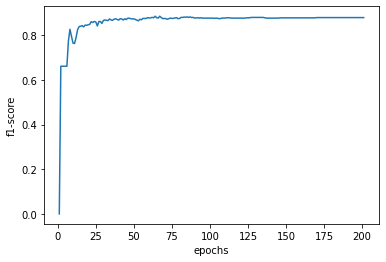

In [53]:
sns.lineplot(data={"f1-score": val_f1_score_history,
                   "epochs": list(range(1, EPOCHS + 2))}, x="epochs", y="f1-score")

# 9. Проверим точность нашей модели на тест части датасета

In [54]:
X_test = torch.Tensor(X_test)

Y_test = torch.Tensor(np.array(Y_test, dtype=np.float64)).type(torch.LongTensor)

best_model.eval()
y_head = best_model(X_test)
y_pred = torch.max(y_head, 1)[1]

for i in sample(list(range(500)), 10):
    print(test_title[i], "pred", y_pred[i].item(), "is_fake", int(Y_test[i].item()))

print("\nModel accuracy is ", f1_score(y_pred, Y_test))
model_plot = input()
if model_plot != "":
    with open("used_models.txt", mode="a") as f:
        f.write(model_plot + ";" + str(EPOCHS) + ";" + str(f1_score(y_pred, Y_test)) + "\n")

От коронавируса скончался последний гомеопат России pred 1 is_fake 1
Справедливым перераспределением акций американских компаний займётся Госплан США pred 1 is_fake 1
Замечено массовое исчезновение всех насекомых мира pred 1 is_fake 0
Ученые посчитали время роста гигантских кристаллов pred 0 is_fake 0
К проекту с Джорджем Клуни и Хью Лори присоединилась девочка-робот pred 0 is_fake 0
СПЧ призвал амнистировать граждан, вовремя не сообщивших о местах расположения выгребных ям pred 1 is_fake 1
Специалисты из Палермо помогут Москве бороться с последствиями снегопадов pred 1 is_fake 1
«Включим программу Киселёва и покажем телевизорам фигу»: Леонид Волков анонсировал новую акцию протеста pred 1 is_fake 1
Русская Википедия удалила статью об Алексее Навальном из-за потери энциклопедической значимости персоны pred 1 is_fake 1
В Госдуме предложили перевести все регионы России на московское время pred 1 is_fake 1

Model accuracy is  0.8630136986301371



## 10. Создаём предсказания для тестовых данных

In [55]:
test_data = pd.read_csv("dataset/test.tsv", sep="\t", header=0)
test_data = data.sample(frac=1)

new_title = []
for txt in tqdm.notebook.tqdm(data.title):
    new_title.append(sentence_editor(txt))

title_matrix = np.array([[0] * 1024], dtype=float)
batch_size = 32
for i in tqdm.notebook.tqdm(range(0, len(new_title), batch_size)):
    title_matrix = np.append(title_matrix, 
                             elmo_model.get_elmo_vector_average([x.split() for x in new_title[i:i + batch_size]]), 
                             axis=0)

title_matrix = np.delete(title_matrix, 0, axis=0)
title_matrix.shape

y_head = best_model(torch.Tensor(title_matrix))
y_pred = torch.max(y_head, 1)[1]

test_data.is_fake = y_pred
test_data.to_csv("predictions.tsv", index=False)

test_data.head(10)

  0%|          | 0/5758 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

KeyboardInterrupt: 